# TellCo — User Analytics (Final Notebook)

This notebook contains the full project pipeline for the telecom user analytics assignment: data loading, cleaning, EDA, feature engineering, PCA, clustering, experience & satisfaction scoring, model training, and export.

## Requirements

Install packages with:
```bash
pip install -r requirements.txt
```

## 1. Imports & Load Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib
import os

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

FIELDS_PATH = "Field Descriptions.xlsx - Sheet1.csv"
DATA_PATH = "telcom_data (2).xlsx - Sheet1.csv"

field_desc = pd.read_csv(FIELDS_PATH)
telcom_data = pd.read_csv(DATA_PATH)

print('Field descriptions shape:', field_desc.shape)
print('Telcom data shape:', telcom_data.shape)

Field descriptions shape: (56, 2)
Telcom data shape: (150001, 55)


## 2. Data Dictionary (metadata)

In [6]:
field_dict = dict(zip(field_desc['Fields'], field_desc['Description']))
field_desc.head(20)

,Fields,Description
0,bearer id,xDr session identifier
1,Dur. (ms),Total Duration of the xDR (in ms)
2,Start,Start time of the xDR (first frame timestamp)
3,Start ms,Milliseconds offset of start time for the xDR ...
4,End,End time of the xDR (last frame timestamp)
5,End ms,Milliseconds offset of end time of the xDR (la...
6,Dur. (s),Total Duration of the xDR (in s)
7,IMSI,International Mobile Subscriber Identity
8,MSISDN/Number,MS International PSTN/ISDN Number of mobile - ...
9,IMEI,International Mobile Equipment Identity


## 3. Quick Data Exploration

In [8]:
telcom_data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311450e+19,4/4/19 12:01,770.0,4/25/19 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16457E+15,42.0,5.0,23.0,44.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,37624.0,38787.0,1.823653e+09,Samsung,Samsung Galaxy A5 Sm-A520F,NaN,NaN,NaN,NaN,NaN,NaN,213.0,214.0,1545765.0,24420.0,1634479.0,1271433.0,3563542.0,137762.0,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311450e+19,4/9/19 13:04,235.0,4/25/19 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,65.0,5.0,16.0,26.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,168.0,3560.0,1.365104e+09,Samsung,Samsung Galaxy J5 (Sm-J530),NaN,NaN,NaN,NaN,NaN,NaN,971.0,1022.0,1926113.0,7165.0,3493924.0,920172.0,629046.0,308339.0,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311450e+19,4/9/19 17:42,1.0,4/25/19 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,NaN,NaN,6.0,9.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.361763e+09,Samsung,Samsung Galaxy A8 (2018),NaN,NaN,NaN,NaN,NaN,NaN,751.0,695.0,1684053.0,42224.0,8535055.0,1694064.0,2690151.0,672973.0,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311450e+19,4/10/19 0:31,486.0,4/25/19 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,NaN,NaN,44.0,44.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,3330.0,37882.0,1.321510e+09,undefined,undefined,NaN,NaN,NaN,NaN,NaN,NaN,17.0,207.0,644121.0,13372.0,9023734.0,2788027.0,1439754.0,631229.0,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311450e+19,4/12/19 20:10,565.0,4/25/19 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,NaN,NaN,6.0,9.0,NaN,NaN,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.089009e+09,Samsung,Samsung Sm-G390F,NaN,NaN,NaN,NaN,NaN,NaN,607.0,604.0,862600.0,50188.0,6248284.0,1500559.0,1936496.0,173853.0,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [9]:
telcom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [10]:
telcom_data.isnull().sum().sort_values(ascending=False).head(20)

Nb of sec with 37500B < Vol UL              130254
Nb of sec with 6250B < Vol UL < 37500B      111843
Nb of sec with 125000B < Vol DL              97538
TCP UL Retrans. Vol (Bytes)                  96649
Nb of sec with 31250B < Vol DL < 125000B     93586
Nb of sec with 1250B < Vol UL < 6250B        92894
Nb of sec with 6250B < Vol DL < 31250B       88317
TCP DL Retrans. Vol (Bytes)                  88146
HTTP UL (Bytes)                              81810
HTTP DL (Bytes)                              81474
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Last Location Name                            1153
MSISDN/Number                                 1066
Bearer Id                                      991
Nb of sec with Vol UL < 1250B                  793
UL TP < 10 Kbps (%)                            792
10 Kbps < UL TP < 50 Kbps (%)                  792
50 Kbps < UL TP < 300 Kbps (%)                 792
UL TP > 300 Kbps (%)           

## 4. Data Cleaning Utilities

In [12]:
def clean_basic(df, fill_numeric=0, drop_duplicates=True):
    for col in ['Start','End']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    if drop_duplicates:
        df = df.drop_duplicates()
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(fill_numeric)
    for col in df.select_dtypes(include=['object','category']).columns:
        if df[col].isna().sum() > 0:
            try:
                df[col] = df[col].fillna(df[col].mode().iloc[0])
            except Exception:
                df[col] = df[col].fillna('Unknown')
    return df

def treat_outliers_with_mean(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for c in cols:
        if c not in df.columns:
            continue
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 3 * iqr
        upper = q3 + 3 * iqr
        mean_val = df[c].mean()
        df.loc[(df[c] < lower) | (df[c] > upper), c] = mean_val
    return df

print('cleaning helpers ready')

cleaning helpers ready


## 5. Apply Cleaning

In [14]:
telcom_data = clean_basic(telcom_data)
telcom_data = treat_outliers_with_mean(telcom_data)
telcom_data.info()

C:\Users\ompra\AppData\Local\Temp\ipykernel_15864\2936605537.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\ompra\AppData\Local\Temp\ipykernel_15864\2936605537.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Bearer Id                                 150001 non-null  float64       
 1   Start                                     150000 non-null  datetime64[ns]
 2   Start ms                                  150001 non-null  float64       
 3   End                                       150000 non-null  datetime64[ns]
 4   End ms                                    150001 non-null  float64       
 5   Dur. (ms)                                 150001 non-null  float64       
 6   IMSI                                      150001 non-null  float64       
 7   MSISDN/Number                             150001 non-null  float64       
 8   IMEI                                      150001 non-null  float64       
 9   Last Location N

## 6. Aggregate per user

In [16]:
def aggregate_per_user(df, user_col='MSISDN/Number'):
    agg_cols = {}
    agg_cols['session_count'] = ('Bearer Id', 'count') if 'Bearer Id' in df.columns else (user_col, 'count')
    if 'Dur. (s)' in df.columns:
        agg_cols['total_duration_s'] = ('Dur. (s)', 'sum')
    elif 'Dur. (ms)' in df.columns:
        agg_cols['total_duration_s'] = ('Dur. (ms)', lambda x: x.sum()/1000.0)
    if 'Total DL (Bytes)' in df.columns:
        agg_cols['total_dl_bytes'] = ('Total DL (Bytes)', 'sum')
    if 'Total UL (Bytes)' in df.columns:
        agg_cols['total_ul_bytes'] = ('Total UL (Bytes)', 'sum')
    app_prefixes = ['Youtube','Netflix','Gaming','Social','Google','Email','Other']
    for p in app_prefixes:
        dl_col = f"{p} DL (Bytes)"
        ul_col = f"{p} UL (Bytes)"
        if dl_col in df.columns:
            agg_cols[f"{p.lower()}_dl"] = (dl_col, 'sum')
        if ul_col in df.columns:
            agg_cols[f"{p.lower()}_ul"] = (ul_col, 'sum')
    group = df.groupby(user_col).agg(**{k: pd.NamedAgg(column=v[0], aggfunc=v[1]) for k,v in agg_cols.items()})
    if 'total_dl_bytes' in group.columns and 'total_ul_bytes' in group.columns:
        group['total_bytes'] = group['total_dl_bytes'] + group['total_ul_bytes']
    return group.reset_index()

user_feats = aggregate_per_user(telcom_data)
user_feats.head()

,MSISDN/Number,session_count,total_duration_s,total_dl_bytes,total_ul_bytes,youtube_dl,youtube_ul,netflix_dl,netflix_ul,gaming_dl,gaming_ul,google_dl,google_ul,email_dl,email_ul,other_dl,other_ul,total_bytes
0,3.360100e+10,1,116.720,8.426375e+08,36053108.0,14900201.0,6724347.0,10265105.0,16915876.0,8.110911e+08,1367528.0,3337123.0,1051882.0,837400.0,493962.0,377096990.0,9473882.0,8.786906e+08
1,3.360100e+10,1,181.230,1.207552e+08,36104459.0,5324251.0,7107972.0,770569.0,10451194.0,1.050353e+08,14714780.0,4197697.0,1137166.0,2828821.0,478960.0,279557701.0,2152370.0,1.568596e+08
2,3.360100e+10,1,134.969,5.566597e+08,39306820.0,2137272.0,19196298.0,16525919.0,2827981.0,5.290685e+08,9759228.0,3343483.0,99643.0,2436500.0,768880.0,495086501.0,6607171.0,5.959665e+08
3,3.360101e+10,1,49.878,4.019932e+08,20327526.0,4393123.0,2584198.0,1157362.0,784730.0,3.880748e+08,3051292.0,5937765.0,3740728.0,2178618.0,106052.0,25248001.0,10031701.0,4.223207e+08
4,3.360101e+10,2,37.104,1.363130e+09,94280527.0,10339971.0,31193031.0,24971647.0,24230077.0,1.308981e+09,5816727.0,13728668.0,4770948.0,2247808.0,1057661.0,777643713.0,27160771.0,1.457411e+09


## 7. Univariate Analysis & Dispersion

In [18]:
user_feats.describe().T

,count,mean,std,min,25%,50%,75%,max
MSISDN/Number,103576.0,3.367078e+10,4.825498e+07,3.360100e+10,3.365069e+10,3.366322e+10,3.367853e+10,4.158517e+10
session_count,103576.0,1.448222e+00,1.718824e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.527000e+03
total_duration_s,103576.0,1.436055e+02,1.566178e+03,7.142000e+00,7.185475e+01,1.027325e+02,1.727980e+02,5.025412e+05
total_dl_bytes,103576.0,6.584200e+08,7.824995e+09,8.827082e+06,3.147826e+08,5.706166e+08,8.075034e+08,2.514512e+12
total_ul_bytes,103576.0,5.955222e+07,7.055348e+08,2.866892e+06,3.639591e+07,4.680564e+07,6.573785e+07,2.268292e+11
youtube_dl,103576.0,1.684872e+07,1.995487e+08,5.300000e+01,7.643925e+06,1.461914e+07,2.114222e+07,6.411432e+10
youtube_ul,103576.0,1.594407e+07,1.885149e+08,1.060000e+02,7.257437e+06,1.386892e+07,1.997947e+07,6.056993e+10
netflix_dl,103576.0,1.683826e+07,2.014561e+08,4.200000e+01,7.587096e+06,1.463752e+07,2.113662e+07,6.472958e+10
netflix_ul,103576.0,1.593298e+07,1.892531e+08,3.500000e+01,7.207696e+06,1.388726e+07,2.000926e+07,6.080792e+10
gaming_dl,103576.0,6.112143e+08,7.265883e+09,2.516000e+03,2.792084e+08,5.327067e+08,7.672036e+08,2.334599e+12


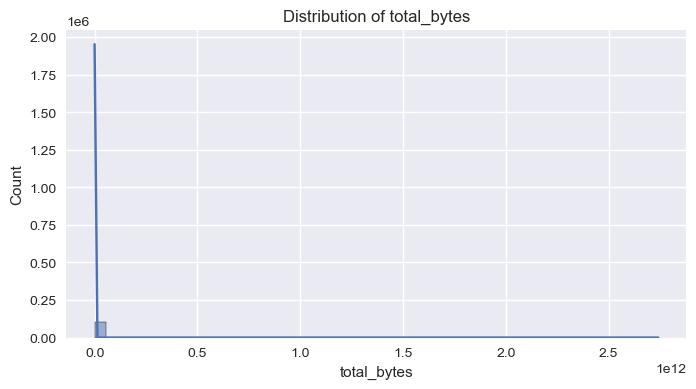

In [19]:
col = 'total_bytes' if 'total_bytes' in user_feats.columns else ('total_dl_bytes' if 'total_dl_bytes' in user_feats.columns else None)
if col:
    plt.figure(figsize=(8,4))
    sns.histplot(user_feats[col].dropna(), bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
else:
    print('No total bytes column found')

### Non-graphical dispersion measures

In [21]:
num = user_feats.select_dtypes(include=[np.number]).columns.tolist()
disp = pd.DataFrame(index=num)
disp['mean'] = user_feats[num].mean()
disp['median'] = user_feats[num].median()
disp['std'] = user_feats[num].std()
disp['var'] = user_feats[num].var()
disp['IQR'] = user_feats[num].quantile(0.75) - user_feats[num].quantile(0.25)
disp

,mean,median,std,var,IQR
MSISDN/Number,3.367078e+10,3.366322e+10,4.825498e+07,2.328543e+15,2.784210e+07
session_count,1.448222e+00,1.000000e+00,1.718824e+01,2.954354e+02,1.000000e+00
total_duration_s,1.436055e+02,1.027325e+02,1.566178e+03,2.452912e+06,1.009433e+02
total_dl_bytes,6.584200e+08,5.706166e+08,7.824995e+09,6.123055e+19,4.927208e+08
total_ul_bytes,5.955222e+07,4.680564e+07,7.055348e+08,4.977793e+17,2.934193e+07
youtube_dl,1.684872e+07,1.461914e+07,1.995487e+08,3.981969e+16,1.349830e+07
youtube_ul,1.594407e+07,1.386892e+07,1.885149e+08,3.553785e+16,1.272203e+07
netflix_dl,1.683826e+07,1.463752e+07,2.014561e+08,4.058455e+16,1.354953e+07
netflix_ul,1.593298e+07,1.388726e+07,1.892531e+08,3.581672e+16,1.280156e+07
gaming_dl,6.112143e+08,5.327067e+08,7.265883e+09,5.279306e+19,4.879952e+08


## 8. Bivariate Analysis — app vs total

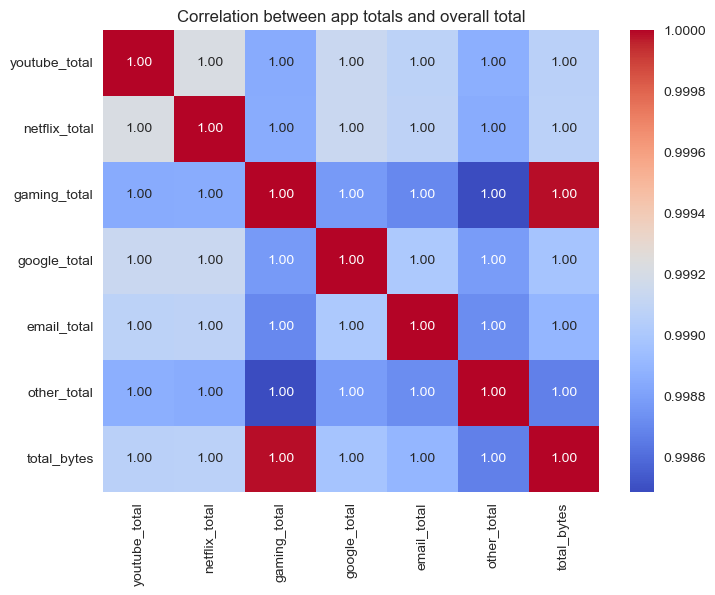

In [23]:
apps = ['youtube','netflix','gaming','social','google','email','other']
for a in apps:
    dl = f'{a}_dl'
    ul = f'{a}_ul'
    if dl in user_feats.columns and ul in user_feats.columns:
        user_feats[f'{a}_total'] = user_feats[dl] + user_feats[ul]

corr_cols = [c for c in user_feats.columns if c.endswith('_total')]
if 'total_bytes' in user_feats.columns:
    corr_cols.append('total_bytes')

if corr_cols:
    plt.figure(figsize=(8,6))
    sns.heatmap(user_feats[corr_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation between app totals and overall total')
    plt.show()
else:
    print('No app totals found')

## 9. Decile segmentation by total_duration_s

In [25]:
if 'total_duration_s' in user_feats.columns:
    user_feats['duration_decile'] = pd.qcut(user_feats['total_duration_s'], 10, labels=False) + 1
    decile_agg = user_feats.groupby('duration_decile')['total_bytes'].sum().reset_index()
    decile_agg
else:
    print('No duration column')

## 10. PCA

In [27]:
pca_cols = [c for c in user_feats.columns if c.endswith('_total')]
if not pca_cols:
    pca_cols = [c for c in user_feats.select_dtypes(include=[np.number]).columns if c not in ['session_count']]
pca_cols = pca_cols[:10]
print('PCA cols:', pca_cols)

if pca_cols:
    scaler = StandardScaler()
    X = scaler.fit_transform(user_feats[pca_cols].fillna(0))
    pca = PCA(n_components=min(5, X.shape[1]), random_state=42)
    pcs = pca.fit_transform(X)
    print('Explained variance:', pca.explained_variance_ratio_)
    pd.DataFrame(pcs, columns=[f'PC{i+1}' for i in range(pcs.shape[1])]).head()
else:
    print('No PCA columns')

PCA cols: ['youtube_total', 'netflix_total', 'gaming_total', 'google_total', 'email_total', 'other_total']
Explained variance: [9.99082361e-01 2.52749773e-04 2.19239090e-04 1.67914580e-04
 1.47173063e-04]


## 11. Engagement Analysis

In [29]:
eng_cols = []
if 'session_count' in user_feats.columns:
    eng_cols.append('session_count')
if 'total_duration_s' in user_feats.columns:
    eng_cols.append('total_duration_s')
if 'total_bytes' in user_feats.columns:
    eng_cols.append('total_bytes')

eng_df = user_feats[['MSISDN/Number'] + eng_cols].copy().fillna(0)
eng_df.head()

,MSISDN/Number,session_count,total_duration_s,total_bytes
0,3.360100e+10,1,116.720,8.786906e+08
1,3.360100e+10,1,181.230,1.568596e+08
2,3.360100e+10,1,134.969,5.959665e+08
3,3.360101e+10,1,49.878,4.223207e+08
4,3.360101e+10,2,37.104,1.457411e+09


D:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\Anaconda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Anaconda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\Anaconda\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^

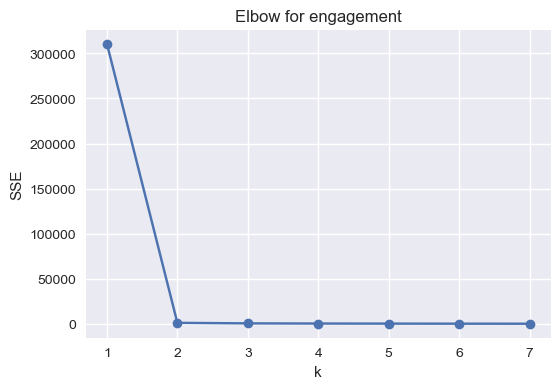

session_count                            total_duration_s  \
                      min   max         mean     sum              min   
eng_cluster                                                             
0                       1     4     1.187118  109463         7.142000   
1                    5527  5527  5527.000000    5527    502541.197681   
2                       1    18     3.080327   35011        66.594000   

                                                          total_bytes  \
                       max           mean           sum           min   
eng_cluster                                                             
0               357.198000     108.070038  9.965030e+06  3.324901e+07   
1            502541.197681  502541.197681  5.025412e+05  2.741341e+12   
2              3643.863863     387.692735  4.406516e+06  1.613794e+08   

                                                       
                      max          mean           sum  
eng_cluster                                            
0            2.043443e+09  5.810542e+08  5.357843e+13  
1            2.741341e+12  2.741341e+12  2.741341e+12  
2            8.846226e+09  1.587623e+09  1.804493e+13

In [30]:
# Elbow
from sklearn.preprocessing import StandardScaler
X = eng_df[eng_cols].values
scaler_eng = StandardScaler()
Xs = scaler_eng.fit_transform(X)
sse = []
for k in range(1,8):
    km = KMeans(n_clusters=k, random_state=42, n_init=5)
    km.fit(Xs)
    sse.append(km.inertia_)
plt.figure(figsize=(6,4)); plt.plot(range(1,8), sse, 'o-'); plt.xlabel('k'); plt.ylabel('SSE'); plt.title('Elbow for engagement'); plt.show()

# KMeans k=3
km3 = KMeans(n_clusters=3, random_state=42, n_init=10)
eng_df['eng_cluster'] = km3.fit_predict(Xs)
eng_df.groupby('eng_cluster')[eng_cols].agg(['min','max','mean','sum'])

### Top 10 customers per engagement metric

In [32]:
for c in eng_cols:
    print('\nTop 10 by', c)
    display(eng_df.sort_values(c, ascending=False).head(10))


Top 10 by session_count


,MSISDN/Number,session_count,total_duration_s,total_bytes,eng_cluster
103575,4.158517e+10,5527,502541.197681,2.741341e+12,1
13526,3.362632e+10,18,2579.965493,7.971167e+09,2
6437,3.361489e+10,17,2257.121356,8.846226e+09,2
13180,3.362578e+10,17,2088.902944,8.499621e+09,2
37052,3.365973e+10,16,3643.863863,7.705863e+09,2
92923,3.376054e+10,15,2228.693767,8.514774e+09,2
76363,3.367588e+10,15,3034.512452,7.891111e+09,2
65118,3.366716e+10,13,1824.542630,5.618394e+09,2
92577,3.376041e+10,12,1799.370041,7.132371e+09,2
13994,3.362708e+10,12,2132.271178,5.754731e+09,2



Top 10 by total_duration_s


,MSISDN/Number,session_count,total_duration_s,total_bytes,eng_cluster
103575,4.158517e+10,5527,502541.197681,2.741341e+12,1
37052,3.365973e+10,16,3643.863863,7.705863e+09,2
76363,3.367588e+10,15,3034.512452,7.891111e+09,2
60338,3.366553e+10,10,2949.867000,4.882856e+09,2
57241,3.366471e+10,11,2927.785000,6.872018e+09,2
13526,3.362632e+10,18,2579.965493,7.971167e+09,2
35436,3.365936e+10,11,2395.219863,4.658437e+09,2
76205,3.367557e+10,9,2313.805863,5.239825e+09,2
6437,3.361489e+10,17,2257.121356,8.846226e+09,2
57360,3.366475e+10,9,2250.808000,3.878861e+09,2



Top 10 by total_bytes


,MSISDN/Number,session_count,total_duration_s,total_bytes,eng_cluster
103575,4.158517e+10,5527,502541.197681,2.741341e+12,1
6437,3.361489e+10,17,2257.121356,8.846226e+09,2
92923,3.376054e+10,15,2228.693767,8.514774e+09,2
13180,3.362578e+10,17,2088.902944,8.499621e+09,2
13526,3.362632e+10,18,2579.965493,7.971167e+09,2
76363,3.367588e+10,15,3034.512452,7.891111e+09,2
37052,3.365973e+10,16,3643.863863,7.705863e+09,2
63028,3.366646e+10,11,2100.622315,7.308501e+09,2
92577,3.376041e+10,12,1799.370041,7.132371e+09,2
57241,3.366471e+10,11,2927.785000,6.872018e+09,2


## 12. Top apps & top users per application

In [34]:
app_total_cols = [c for c in user_feats.columns if c.endswith('_total')]
app_sums = user_feats[app_total_cols].sum().sort_values(ascending=False)
app_sums.head(10)

gaming_total     6.455040e+13
other_total      6.440523e+13
youtube_total    3.396545e+12
netflix_total    3.394314e+12
google_total     1.171102e+12
email_total      3.388676e+11
dtype: float64

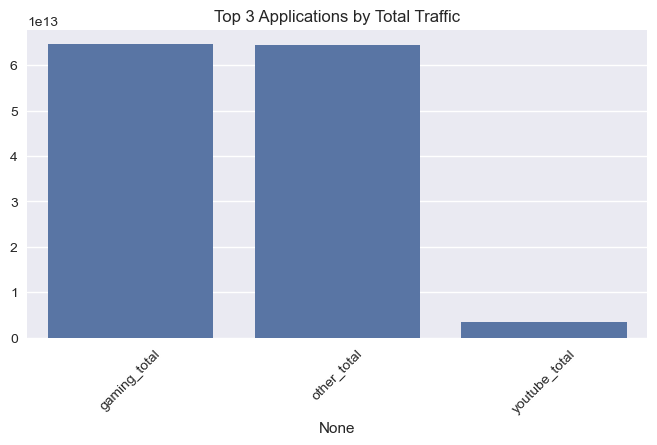

In [35]:
top3_apps = app_sums.head(3).index.tolist()
plt.figure(figsize=(8,4)); sns.barplot(x=app_sums.head(3).index, y=app_sums.head(3).values); plt.title('Top 3 Applications by Total Traffic'); plt.xticks(rotation=45); plt.show()

## 13. Experience Analytics

In [37]:
tcp_cols = [c for c in telcom_data.columns if 'tcp' in c.lower() or 'retrans' in c.lower()]
rtt_cols = [c for c in telcom_data.columns if 'rtt' in c.lower()]
thr_cols = [c for c in telcom_data.columns if 'throughput' in c.lower()]
tcp_cols, rtt_cols, thr_cols

(['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)'],
 ['Avg RTT DL (ms)', 'Avg RTT UL (ms)'],
 [])

In [38]:
agg_map = {}
if tcp_cols:
    agg_map['avg_tcp_retrans'] = (tcp_cols[0], 'mean')
if rtt_cols:
    agg_map['avg_rtt'] = (rtt_cols[0], 'mean')
if thr_cols:
    agg_map['avg_throughput'] = (thr_cols[0], 'mean')

if agg_map:
    exp_group = telcom_data.groupby('MSISDN/Number').agg(**{k: pd.NamedAgg(column=v[0], aggfunc=v[1]) for k,v in agg_map.items()}).reset_index()
    # handset
    handset_col = None
    for c in ['Last Handset Type','Handset Type','IMEI','Model','Device Type']:
        if c in telcom_data.columns:
            handset_col = c; break
    if handset_col:
        mode_handset = telcom_data.groupby('MSISDN/Number')[handset_col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown').reset_index().rename(columns={handset_col:'handset_type'})
        exp_group = exp_group.merge(mode_handset, on='MSISDN/Number', how='left')
    exp_group.head()
else:
    print('No TCP/RTT/Throughput columns detected')

### Top/bottom/frequent lists for experience metrics

In [40]:
def top_bottom_freq(series, n=10):
    s_sorted = series.dropna().sort_values()
    topn = s_sorted.tail(n).values.tolist()
    bottomn = s_sorted.head(n).values.tolist()
    freq = series.value_counts().head(n).index.tolist()
    return topn, bottomn, freq

for col in (tcp_cols[:1] + rtt_cols[:1] + thr_cols[:1]):
    if col in telcom_data.columns:
        print('Column:', col)
        topn, bottomn, freq = top_bottom_freq(telcom_data[col])
        print('Top:', topn)
        print('Bottom:', bottomn)
        print('Freq:', freq)

Column: TCP DL Retrans. Vol (Bytes)
Top: [8581257.772894848, 8581257.772894848, 8581257.772894848, 8581257.772894848, 8581257.772894848, 8581257.772894848, 8581257.772894848, 8581257.772894848, 8581257.772894848, 8581257.772894848]
Bottom: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Freq: [0.0, 8581257.772894848, 1330.0, 2660.0, 38.0, 92.0, 1318.0, 543.0, 3990.0, 76.0]
Column: Avg RTT DL (ms)
Top: [176.0, 176.0, 176.0, 176.0, 176.0, 176.0, 176.0, 176.0, 176.0, 176.0]
Bottom: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Freq: [0.0, 89.4258104945967, 28.0, 27.0, 34.0, 35.0, 37.0, 36.0, 38.0, 29.0]


### Experience clustering (k=3)

In [42]:
if 'exp_group' in globals():
    exp_metrics = [c for c in exp_group.columns if c.startswith('avg_')]
    Xexp = exp_group[exp_metrics].fillna(0).values
    scaler_exp = StandardScaler()
    Xs_exp = scaler_exp.fit_transform(Xexp)
    km_exp = KMeans(n_clusters=3, random_state=42, n_init=10)
    exp_group['exp_cluster'] = km_exp.fit_predict(Xs_exp)
    exp_group.groupby('exp_cluster')[exp_metrics].agg(['min','max','mean'])
else:
    print('No exp_group to cluster')

## 14. Satisfaction Analysis

In [44]:
if 'eng_df' in globals() and 'exp_group' in globals():
    merged = eng_df.merge(exp_group, on='MSISDN/Number', how='inner', suffixes=('_eng','_exp'))
    eng_metrics = [c for c in eng_df.columns if c not in ['MSISDN/Number','eng_cluster']]
    exp_metrics = [c for c in exp_group.columns if c not in ['MSISDN/Number','exp_cluster','handset_type']]
    scaler_e = StandardScaler().fit(merged[eng_metrics].fillna(0))
    Xeng = scaler_e.transform(merged[eng_metrics].fillna(0))
    km_eng = KMeans(n_clusters=3, random_state=42, n_init=10).fit(Xeng)
    centroids_eng = km_eng.cluster_centers_
    least_idx = np.argmin(np.linalg.norm(centroids_eng, axis=1))
    eng_scores = np.linalg.norm(Xeng - centroids_eng[least_idx], axis=1)
    scaler_x = StandardScaler().fit(merged[exp_metrics].fillna(0))
    Xexp = scaler_x.transform(merged[exp_metrics].fillna(0))
    km_ex = KMeans(n_clusters=3, random_state=42, n_init=10).fit(Xexp)
    cent_ex = km_ex.cluster_centers_
    worst_idx = np.argmin(np.linalg.norm(cent_ex, axis=1))
    exp_scores = np.linalg.norm(Xexp - cent_ex[worst_idx], axis=1)
    scores = pd.DataFrame({'MSISDN/Number': merged['MSISDN/Number'],
                           'engagement_score': eng_scores,
                           'experience_score': exp_scores})
    scores['satisfaction_score'] = (scores['engagement_score'] + scores['experience_score'])/2.0
    scores.sort_values('satisfaction_score', ascending=False).head(10)
else:
    print('Need both engagement and experience results')

### Train regression model to predict satisfaction

In [46]:
if 'scores' in globals():
    X = scores[['engagement_score','experience_score']].values
    y = scores['satisfaction_score'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    print('Train R2:', rf.score(X_train, y_train))
    print('Test R2:', rf.score(X_test, y_test))
    os.makedirs('models', exist_ok=True)
    joblib.dump(rf, 'models/satisfaction_model.joblib')
    print('Model saved')

Train R2: 0.9999903075498005
Test R2: 0.07860588736072227
Model saved


In [ ]:
#15. Export & Deployment notes
#Use the provided Dockerfile to containerize the Streamlit app.
#Use the mysql export snippet in the README to push results to MySQL.